<a href="https://colab.research.google.com/github/sdannels/synthetic_time_series_forecasting/blob/main/synthetic_forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn fredapi statsmodels datetime keras math

In [14]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import datetime as dt
import torch
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Dropout
from keras.models import load_model
#from gretel_synthetics.timeseries_dgan.dgan import DGAN
#from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# read in economic data and convert to DateTime index
df = pd.read_csv("/content/drive/MyDrive/Synthetic_data/fred_data", index_col = 0)
df.index = pd.DatetimeIndex(df.index)
df.index.name = 'date'
df = df.reset_index()
# create lag of 1 and 10-year yield
df['DGS1_lag'] = df['DGS1'].shift(1)
df['DGS10_lag'] = df['DGS10'].shift(1)

In [3]:
# function to plot forecasting results
def plot_forecast_compare(compare_df, forecast_var_name, actual_var_name, title,
                          RMSE = True, MAPE = True):
  """
  compare_df is dataframe with forecasted, actual, and date values
  forecast_var_name, actual_var_name are strings for column names in compare_df
  title is a string for the title of the graph
  RMSE and MAPE: True if want to output those statistics above graph
  """
  # print RMSE
  if RMSE == True:
    model_rmse = math.sqrt(mean_squared_error(compare_df[actual_var_name], compare_df[forecast_var_name]))
    print(f'RMSE: {model_rmse}')
  
  # print MAPE
  if MAPE == True:
    model_mape = mean_absolute_percentage_error(compare_df[actual_var_name], compare_df[forecast_var_name])*100
    print(f'MAPE: {model_mape}')

  # plot results
  plt.plot(compare_df['date'], compare_df[actual_var_name], label = 'Actual')
  plt.plot(compare_df['date'], compare_df[forecast_var_name], label = 'Forecast')
  plt.title(title)
  plt.legend()
  plt.xticks(rotation = 45)
  plt.show()

# Autoregressive Model

In [4]:
# set last date for training data and first date for forecasting (next day)
last_train_date = '12-31-2016'
start_forecast_date = dt.datetime.strptime(last_train_date, '%m-%d-%Y') + dt.timedelta(days = 3)
start_forecast_date = start_forecast_date.strftime('%m-%d-%Y')
end_forecast_date = '01-11-2023'

# split up training and testing data
train_df = df[df['date'] <= last_train_date]
test_df = df[df['date'] > last_train_date]

## 1-year Treasury Yield

In [5]:
# choose optimal number of lags by BIC
opt_mod = ar_select_order(train_df['DGS1'], exog = train_df['DGS10_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod = AutoReg(train_df['DGS1'], exog = train_df['DGS10_lag'], lags = 13, trend = 'c',
              missing = 'drop', old_names = False)
res = mod.fit(cov_type="HC0")
print(res.summary())

Chosen lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
                            AutoReg Model Results                             
Dep. Variable:                   DGS1   No. Observations:                13734
Model:                  AutoReg-X(13)   Log Likelihood               14775.944
Method:               Conditional MLE   S.D. of innovations              0.082
Date:                Fri, 27 Jan 2023   AIC                             -4.989
Time:                        05:30:50   BIC                             -4.981
Sample:                            13   HQIC                            -4.986
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.325      0.745      -0.004       0.005
DGS1.L1        1.1031      0.021     51.607      0.000       1.061       1.14

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [6]:
# find start and end index numbers
df_index = df.copy()
start_forecast_index = df_index.index[df_index['date'] == start_forecast_date][0]
end_forecast_index = df_index.index[df_index['date'] == end_forecast_date][0]
del df_index

# forecast
ar_preds = res.predict(start = start_forecast_index, end = end_forecast_index, 
                       exog_oos = test_df['DGS10_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.2093689916881336
MAPE: 535.1963216815966


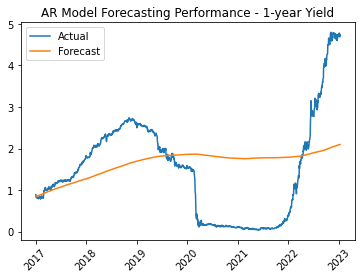

In [7]:
# compare forecasts to actuals
actuals = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), 'DGS1']
actuals_df = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS1']]
ar_compare = pd.concat([actuals_df, ar_preds], axis = 1)
ar_compare.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 1-year Yield')

## 10-year Treasury Yield

In [8]:
# choose optimal number of lags by BIC
opt_mod10 = ar_select_order(train_df['DGS10'], exog = train_df['DGS1_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod10.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod10 = AutoReg(train_df['DGS10'], exog = train_df['DGS1_lag'], lags = 2, trend = 'c',
              missing = 'drop', old_names = False)
res10 = mod10.fit(cov_type="HC0")
print(res10.summary())

Chosen lags: [1 2]
                            AutoReg Model Results                             
Dep. Variable:                  DGS10   No. Observations:                13734
Model:                   AutoReg-X(2)   Log Likelihood               17774.416
Method:               Conditional MLE   S.D. of innovations              0.066
Date:                Fri, 27 Jan 2023   AIC                             -5.426
Time:                        05:31:01   BIC                             -5.423
Sample:                             2   HQIC                            -5.425
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.203      0.028       0.000       0.008
DGS10.L1       1.0685      0.015     70.076      0.000       1.039       1.098
DGS10.L2      -0.0703      0.015 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [9]:
# forecast
ar_preds_10 = res10.predict(start = start_forecast_index, end = end_forecast_index, 
                            exog_oos = test_df['DGS1_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.3037903165314702
MAPE: 85.31142329159722


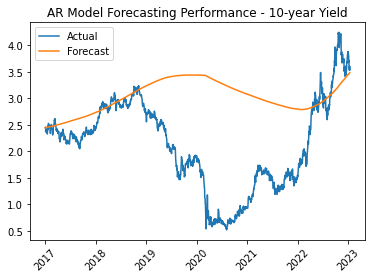

In [10]:
# compare forecasts to actuals
actuals_df10 = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS10']]
ar_compare10 = pd.concat([actuals_df10, ar_preds_10], axis = 1)
ar_compare10.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare10,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 10-year Yield')

# LSTM Neural Network (Real Data)

Parts of code adapted from examples in: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [11]:
# function to reformat data from df to numpy array
def df_to_np(df, cols):
  """
    df: pandas DataFrame
    cols = list of column names from df to include
  """
  data = df[cols]
  data = data.to_numpy()
  return data

# function to split data into samples for NN
def split_NN_samples(data, n_steps):
  X, y = list(), list()
  for i in range(len(data)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(data)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [12]:
# select features from df and # of steps for each sample
feature_cols = ['DGS1', 'DGS10']
n_steps = 25

# format training data
train_data = df_to_np(train_df, feature_cols)
train_x, train_y = split_NN_samples(data = train_data, n_steps = n_steps)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x.shape)
n_features = train_x.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y.shape)

(13710, 25, 2)
(13710, 2)


In [17]:
# define model
LSTM_model = Sequential()
LSTM_model.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_model.add(LSTM(25, activation='tanh'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(n_features))
LSTM_model.compile(optimizer='adam', loss='mse')

In [18]:
# if true, load a pretrained model instead of training
load_pretrain = True

if load_pretrain == True:
  LSTM_model = load_model("/content/drive/MyDrive/Models/LSTM_model")
else:
  # train model
  LSTM_model.fit(train_x, train_y, epochs = 50, verbose = 2)

Epoch 1/50
429/429 - 5s - loss: 7.6796 - 5s/epoch - 12ms/step
Epoch 2/50
429/429 - 2s - loss: 1.1057 - 2s/epoch - 5ms/step
Epoch 3/50
429/429 - 2s - loss: 0.6884 - 2s/epoch - 5ms/step
Epoch 4/50
429/429 - 2s - loss: 0.6042 - 2s/epoch - 5ms/step
Epoch 5/50
429/429 - 2s - loss: 0.5598 - 2s/epoch - 5ms/step
Epoch 6/50
429/429 - 2s - loss: 0.5424 - 2s/epoch - 5ms/step
Epoch 7/50
429/429 - 2s - loss: 0.5108 - 2s/epoch - 5ms/step
Epoch 8/50
429/429 - 2s - loss: 0.5101 - 2s/epoch - 5ms/step
Epoch 9/50
429/429 - 2s - loss: 0.4849 - 2s/epoch - 5ms/step
Epoch 10/50
429/429 - 2s - loss: 0.4701 - 2s/epoch - 5ms/step
Epoch 11/50
429/429 - 2s - loss: 0.4592 - 2s/epoch - 5ms/step
Epoch 12/50
429/429 - 2s - loss: 0.4697 - 2s/epoch - 5ms/step
Epoch 13/50
429/429 - 2s - loss: 0.4250 - 2s/epoch - 5ms/step
Epoch 14/50
429/429 - 2s - loss: 0.4132 - 2s/epoch - 5ms/step
Epoch 15/50
429/429 - 2s - loss: 0.4028 - 2s/epoch - 5ms/step
Epoch 16/50
429/429 - 2s - loss: 0.3836 - 2s/epoch - 5ms/step
Epoch 17/50
429/

In [34]:
# save model after training
LSTM_model.save("/content/drive/MyDrive/Models/LSTM_model")

In [19]:
# format test data
test_df = df[(df['date'] > last_train_date) & (df['date'] <= end_forecast_date)]
test_data = df_to_np(test_df, feature_cols)
test_x, test_y = split_NN_samples(data = test_data, n_steps = n_steps)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x.shape)
# test_y shape is (# of samples, # of features)
print(test_y.shape)

(1482, 25, 2)
(1482, 2)


In [20]:
# forecast on test data
yhat = LSTM_model.predict(test_x, verbose=0)

RMSE: 0.07695114283208526
MAPE: 7.793974239625802


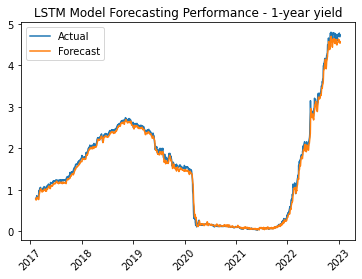

RMSE: 0.2525160914350324
MAPE: 15.903430506166222


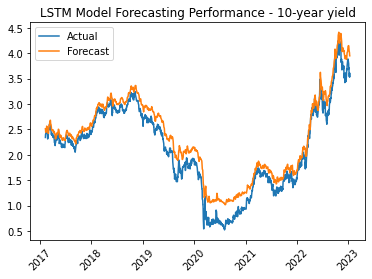

In [21]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_compare = pd.concat([pd.DataFrame(yhat), pd.DataFrame(test_y)], axis = 1)
LSTM_compare = pd.concat([date_compare, LSTM_compare], axis = 1)
LSTM_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Model Forecasting Performance - 10-year yield')

# LSTM Neural Network (Synthetic Data)

This model is trained on synthetic data, but tested on the same real data as above.

In [22]:
# load previously trained model
#if torch.cuda.is_available() == True:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt')
#else:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt', map_location = torch.device('cpu'))

# generate synthetic data in numpy array format
# synthetic_attributes, synthetic_features = model.generate_numpy(1000)

# load synthetic data from DGAN_generation notebook
synthetic_features = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped")
### WARNING: ENSURE THAT SHAPE OF DATA HAS NOT CHANGED IN DGAN_Generation NOTEBOOK ###############
synthetic_features = synthetic_features.reshape(1000, 125, 2)
synthetic_attributes = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_attributes")
synthetic_attributes = synthetic_attributes.reshape(-1, 1)

In [23]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples(data = synthetic_features[i, :, :], n_steps = n_steps)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x, synth_train_y = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x = np.concatenate([synth_train_x, synth_train_x_iter], axis = 0)
    synth_train_y = np.concatenate([synth_train_y, synth_train_y_iter], axis = 0)

print(synth_train_x.shape)
print(synth_train_y.shape)

(100000, 25, 2)
(100000, 2)


In [24]:
# define model (should be same as model used for real data)
LSTM_synth_model = Sequential()
LSTM_synth_model.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_synth_model.add(LSTM(25, activation='tanh'))
LSTM_synth_model.add(Dropout(0.2))
LSTM_synth_model.add(Dense(n_features))
LSTM_synth_model.compile(optimizer='adam', loss='mse')

In [25]:
# if true, load a pretrained model instead of training
load_synth_pretrain = True

if load_synth_pretrain == True:
  LSTM_synth_model = load_model("/content/drive/MyDrive/Models/LSTM_synth_model")
else:
  # train model
  LSTM_synth_model.fit(synth_train_x, synth_train_y, epochs = 50, verbose = 2)

Epoch 1/50
3125/3125 - 15s - loss: 1.4531 - 15s/epoch - 5ms/step
Epoch 2/50
3125/3125 - 13s - loss: 0.5195 - 13s/epoch - 4ms/step
Epoch 3/50
3125/3125 - 13s - loss: 0.3505 - 13s/epoch - 4ms/step
Epoch 4/50
3125/3125 - 13s - loss: 0.2654 - 13s/epoch - 4ms/step
Epoch 5/50
3125/3125 - 14s - loss: 0.2051 - 14s/epoch - 4ms/step
Epoch 6/50
3125/3125 - 13s - loss: 0.1774 - 13s/epoch - 4ms/step
Epoch 7/50
3125/3125 - 14s - loss: 0.1595 - 14s/epoch - 5ms/step
Epoch 8/50
3125/3125 - 13s - loss: 0.1499 - 13s/epoch - 4ms/step
Epoch 9/50
3125/3125 - 13s - loss: 0.1404 - 13s/epoch - 4ms/step
Epoch 10/50
3125/3125 - 13s - loss: 0.1389 - 13s/epoch - 4ms/step
Epoch 11/50
3125/3125 - 13s - loss: 0.1378 - 13s/epoch - 4ms/step
Epoch 12/50
3125/3125 - 13s - loss: 0.1374 - 13s/epoch - 4ms/step
Epoch 13/50
3125/3125 - 13s - loss: 0.1352 - 13s/epoch - 4ms/step
Epoch 14/50
3125/3125 - 13s - loss: 0.1335 - 13s/epoch - 4ms/step
Epoch 15/50
3125/3125 - 13s - loss: 0.1364 - 13s/epoch - 4ms/step
Epoch 16/50
3125/31

In [35]:
# save model after training
LSTM_synth_model.save("/content/drive/MyDrive/Models/LSTM_synth_model")

In [26]:
# forecast on test data (trained on synthetic data, but tested on real data)
yhat_synth = LSTM_synth_model.predict(test_x, verbose=0)

RMSE: 0.04622158936156982
MAPE: 9.412970428503675


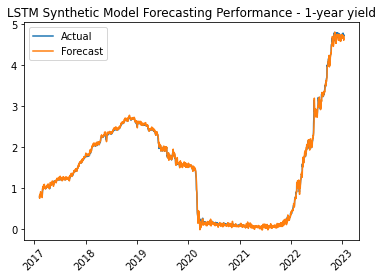

RMSE: 0.06220047967613702
MAPE: 2.709468567054846


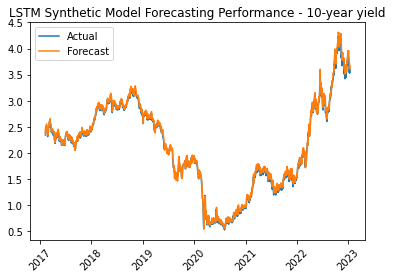

In [27]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_synth_compare = pd.concat([pd.DataFrame(yhat_synth), pd.DataFrame(test_y)], axis = 1)
LSTM_synth_compare = pd.concat([date_compare, LSTM_synth_compare], axis = 1)
LSTM_synth_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 10-year yield')

# LSTM Neural Network (Combined data)

Real-data is combined with synthetic to augment the amount of available samples

In [28]:
# combine features for training
train_x_combined = np.concatenate([train_x, synth_train_x], axis = 0)
print(train_x_combined.shape)
train_y_combined = np.concatenate([train_y, synth_train_y], axis = 0)
print(train_y_combined.shape)

(113710, 25, 2)
(113710, 2)


In [29]:
# define model (should be same as model used for real data)
LSTM_comb_model = Sequential()
LSTM_comb_model.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_comb_model.add(LSTM(25, activation='tanh'))
LSTM_comb_model.add(Dropout(0.2))
LSTM_comb_model.add(Dense(n_features))
LSTM_comb_model.compile(optimizer='adam', loss='mse')

In [30]:
# if true, load a pretrained model instead of training
load_comb_pretrain = True

if load_comb_pretrain == True:
  LSTM_comb_model = load_model("/content/drive/MyDrive/Models/LSTM_comb_model")
else:
  # train model
  LSTM_comb_model.fit(train_x_combined, train_y_combined, epochs = 50, verbose = 2)

Epoch 1/50
3554/3554 - 21s - loss: 1.4924 - 21s/epoch - 6ms/step
Epoch 2/50
3554/3554 - 17s - loss: 0.4857 - 17s/epoch - 5ms/step
Epoch 3/50
3554/3554 - 17s - loss: 0.3202 - 17s/epoch - 5ms/step
Epoch 4/50
3554/3554 - 17s - loss: 0.2328 - 17s/epoch - 5ms/step
Epoch 5/50
3554/3554 - 20s - loss: 0.1870 - 20s/epoch - 6ms/step
Epoch 6/50
3554/3554 - 17s - loss: 0.1588 - 17s/epoch - 5ms/step
Epoch 7/50
3554/3554 - 17s - loss: 0.1446 - 17s/epoch - 5ms/step
Epoch 8/50
3554/3554 - 17s - loss: 0.1412 - 17s/epoch - 5ms/step
Epoch 9/50
3554/3554 - 17s - loss: 0.1381 - 17s/epoch - 5ms/step
Epoch 10/50
3554/3554 - 27s - loss: 0.1387 - 27s/epoch - 8ms/step
Epoch 11/50
3554/3554 - 19s - loss: 0.1358 - 19s/epoch - 5ms/step
Epoch 12/50
3554/3554 - 17s - loss: 0.1349 - 17s/epoch - 5ms/step
Epoch 13/50
3554/3554 - 17s - loss: 0.1334 - 17s/epoch - 5ms/step
Epoch 14/50
3554/3554 - 17s - loss: 0.1363 - 17s/epoch - 5ms/step
Epoch 15/50
3554/3554 - 17s - loss: 0.1361 - 17s/epoch - 5ms/step
Epoch 16/50
3554/35

In [36]:
# save model after training
LSTM_comb_model.save("/content/drive/MyDrive/Models/LSTM_comb_model")

In [31]:
# forecast on test data (trained on synthetic data, but tested on real data)
yhat_comb = LSTM_comb_model.predict(test_x, verbose=0)

RMSE: 0.07287519766368211
MAPE: 8.367651697665849


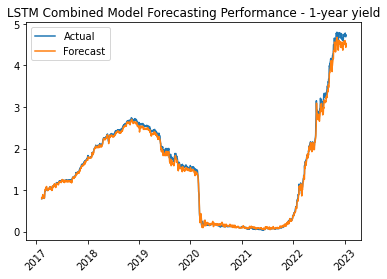

RMSE: 0.07293165395131636
MAPE: 3.4843922422114066


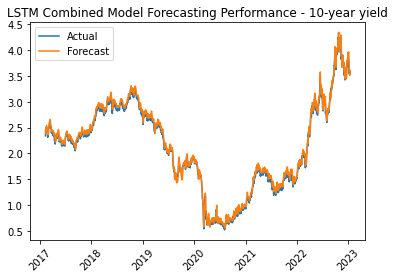

In [32]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_comb_compare = pd.concat([pd.DataFrame(yhat_comb), pd.DataFrame(test_y)], axis = 1)
LSTM_comb_compare = pd.concat([date_compare, LSTM_comb_compare], axis = 1)
LSTM_comb_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_comb_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Combined Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_comb_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Combined Model Forecasting Performance - 10-year yield')

# Multi-Step LSTM (Real Data)

In [37]:
n_steps_in = 25
# set number of steps ahead to forecast
n_steps_out = 15

# function to split samples for multiple steps ahead
def split_NN_samples_multistep(data, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(data)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out
  # check if we are beyond the sequence
  if out_end_ix > len(data):
    break
  # gather input and output parts of the pattern
  seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, :]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [38]:
# create training samples
train_x_multi, train_y_multi = split_NN_samples_multistep(data = train_data, n_steps_in = n_steps_in, n_steps_out = n_steps_out)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x_multi.shape)
n_features_multi = train_x_multi.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y_multi.shape)

(13696, 25, 2)
(13696, 15, 2)


In [39]:
# format test data
test_x_multi, test_y_multi = split_NN_samples_multistep(data = test_data, n_steps_in = n_steps_in, n_steps_out = n_steps_out)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x_multi.shape)
# test_y shape is (# of samples, # of features)
print(test_y_multi.shape)

(1468, 25, 2)
(1468, 15, 2)


In [43]:
# define model
LSTM_model_multi = Sequential()
LSTM_model_multi.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_model_multi.add(LSTM(25, activation='tanh'))
LSTM_model_multi.add(Dropout(0.2))
LSTM_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_model_multi.compile(optimizer='adam', loss='mse')

In [44]:
# if true, load a pretrained model instead of training
load_multi_pretrain = True

if load_multi_pretrain == True:
  LSTM_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_model_multi")
else:
  # train model
  LSTM_model_multi.fit(train_x_multi, train_y_multi, epochs = 50, verbose = 2)

Epoch 1/50
428/428 - 4s - loss: 13.0624 - 4s/epoch - 9ms/step
Epoch 2/50
428/428 - 2s - loss: 2.1849 - 2s/epoch - 4ms/step
Epoch 3/50
428/428 - 2s - loss: 1.2128 - 2s/epoch - 4ms/step
Epoch 4/50
428/428 - 2s - loss: 0.8311 - 2s/epoch - 4ms/step
Epoch 5/50
428/428 - 2s - loss: 0.7294 - 2s/epoch - 4ms/step
Epoch 6/50
428/428 - 2s - loss: 0.6460 - 2s/epoch - 4ms/step
Epoch 7/50
428/428 - 2s - loss: 0.5930 - 2s/epoch - 4ms/step
Epoch 8/50
428/428 - 2s - loss: 0.5828 - 2s/epoch - 4ms/step
Epoch 9/50
428/428 - 2s - loss: 0.5644 - 2s/epoch - 4ms/step
Epoch 10/50
428/428 - 2s - loss: 0.5210 - 2s/epoch - 5ms/step
Epoch 11/50
428/428 - 3s - loss: 0.5176 - 3s/epoch - 6ms/step
Epoch 12/50
428/428 - 3s - loss: 0.4924 - 3s/epoch - 7ms/step
Epoch 13/50
428/428 - 2s - loss: 0.4761 - 2s/epoch - 6ms/step
Epoch 14/50
428/428 - 2s - loss: 0.4690 - 2s/epoch - 4ms/step
Epoch 15/50
428/428 - 2s - loss: 0.4561 - 2s/epoch - 4ms/step
Epoch 16/50
428/428 - 2s - loss: 0.4348 - 2s/epoch - 4ms/step
Epoch 17/50
428/

In [45]:
# save model after training
LSTM_model_multi.save("/content/drive/MyDrive/Models/LSTM_model_multi")

In [46]:
# forecast on test data
yhat_multi = LSTM_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.24445960522610063
MAPE: 77.7363479430877


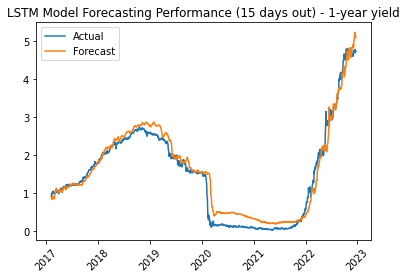

RMSE: 0.2525160914350324
MAPE: 15.903430506166222


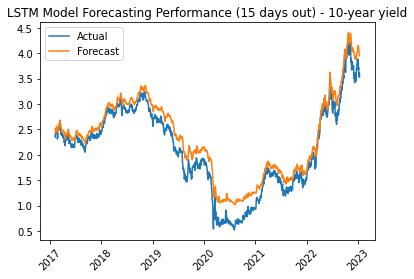

In [47]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_multi_last_day = yhat_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_compare_multi = pd.concat([pd.DataFrame(yhat_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_compare_multi = pd.concat([date_compare, LSTM_compare_multi], axis = 1)
LSTM_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_compare_multi = LSTM_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')

# Multi-Step LSTM (Synthetic Data)

In [48]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples_multistep(data = synthetic_features[i, :, :], 
                                                                      n_steps_in = n_steps_in, n_steps_out = n_steps_out)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x_multi, synth_train_y_multi = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x_multi = np.concatenate([synth_train_x_multi, synth_train_x_iter], axis = 0)
    synth_train_y_multi = np.concatenate([synth_train_y_multi, synth_train_y_iter], axis = 0)

print(synth_train_x_multi.shape)
print(synth_train_y_multi.shape)

(86000, 25, 2)
(86000, 15, 2)


In [49]:
# define model (should be the same as model used for real data)
LSTM_synth_model_multi = Sequential()
LSTM_synth_model_multi.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_synth_model_multi.add(LSTM(25, activation='tanh'))
LSTM_synth_model_multi.add(Dropout(0.2))
LSTM_synth_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_synth_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_synth_model_multi.compile(optimizer='adam', loss='mse')

In [50]:
# if true, load a pretrained model instead of training
load_synth_multi_pretrain = False

if load_synth_multi_pretrain == True:
  LSTM_synth_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_synth_model_multi")
else:
  # train model
  LSTM_synth_model_multi.fit(synth_train_x_multi, synth_train_y_multi, epochs = 50, verbose = 2)

Epoch 1/50
2688/2688 - 17s - loss: 2.6958 - 17s/epoch - 6ms/step
Epoch 2/50
2688/2688 - 14s - loss: 0.7238 - 14s/epoch - 5ms/step
Epoch 3/50
2688/2688 - 13s - loss: 0.5399 - 13s/epoch - 5ms/step
Epoch 4/50
2688/2688 - 13s - loss: 0.4259 - 13s/epoch - 5ms/step
Epoch 5/50
2688/2688 - 13s - loss: 0.3519 - 13s/epoch - 5ms/step
Epoch 6/50
2688/2688 - 13s - loss: 0.2941 - 13s/epoch - 5ms/step
Epoch 7/50
2688/2688 - 14s - loss: 0.2699 - 14s/epoch - 5ms/step
Epoch 8/50
2688/2688 - 14s - loss: 0.2502 - 14s/epoch - 5ms/step
Epoch 9/50
2688/2688 - 13s - loss: 0.2427 - 13s/epoch - 5ms/step
Epoch 10/50
2688/2688 - 14s - loss: 0.2338 - 14s/epoch - 5ms/step
Epoch 11/50
2688/2688 - 13s - loss: 0.2204 - 13s/epoch - 5ms/step
Epoch 12/50
2688/2688 - 13s - loss: 0.2142 - 13s/epoch - 5ms/step
Epoch 13/50
2688/2688 - 13s - loss: 0.2121 - 13s/epoch - 5ms/step
Epoch 14/50
2688/2688 - 13s - loss: 0.2188 - 13s/epoch - 5ms/step
Epoch 15/50
2688/2688 - 13s - loss: 0.2089 - 13s/epoch - 5ms/step
Epoch 16/50
2688/26

In [51]:
# save model after training
LSTM_synth_model_multi.save("/content/drive/MyDrive/Models/LSTM_synth_model_multi")

In [52]:
# forecast on test data (trained on synthetic data, test on real data)
yhat_synth_multi = LSTM_synth_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.35505691762156266
MAPE: 84.60976926286504


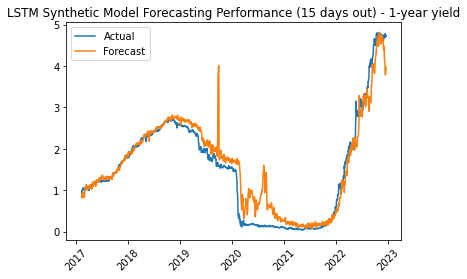

RMSE: 0.5425812018905808
MAPE: 30.50273231142895


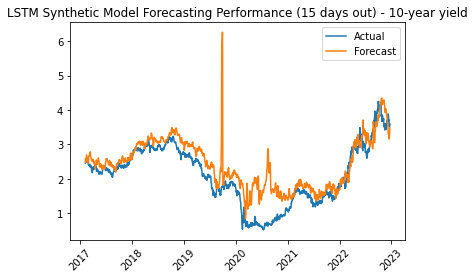

In [53]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_synth_multi_last_day = yhat_synth_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_synth_compare_multi = pd.concat([pd.DataFrame(yhat_synth_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_synth_compare_multi = pd.concat([date_compare, LSTM_synth_compare_multi], axis = 1)
LSTM_synth_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_synth_compare_multi = LSTM_synth_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_synth_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Synthetic Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_synth_compare_multi, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Synthetic Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')

#Multi-Step LSTM (Combined Data)

In [54]:
# combine features for training
train_x_combined_multi = np.concatenate([train_x_multi, synth_train_x_multi], axis = 0)
print(train_x_combined_multi.shape)
train_y_combined_multi = np.concatenate([train_y_multi, synth_train_y_multi], axis = 0)
print(train_y_combined_multi.shape)

(99696, 25, 2)
(99696, 15, 2)


In [55]:
# define model (should be the same as model used for real data)
LSTM_comb_model_multi = Sequential()
LSTM_comb_model_multi.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_comb_model_multi.add(LSTM(25, activation='tanh'))
LSTM_comb_model_multi.add(Dropout(0.2))
LSTM_comb_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_comb_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_comb_model_multi.compile(optimizer='adam', loss='mse')

In [56]:
# if true, load a pretrained model instead of training
load_comb_multi_pretrain = False

if load_comb_multi_pretrain == True:
  LSTM_comb_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_comb_model_multi")
else:
  # train model
  LSTM_comb_model_multi.fit(train_x_combined_multi, train_y_combined_multi, epochs = 50, verbose = 2)

Epoch 1/50
3116/3116 - 19s - loss: 2.5119 - 19s/epoch - 6ms/step
Epoch 2/50
3116/3116 - 15s - loss: 0.6555 - 15s/epoch - 5ms/step
Epoch 3/50
3116/3116 - 15s - loss: 0.4866 - 15s/epoch - 5ms/step
Epoch 4/50
3116/3116 - 16s - loss: 0.3892 - 16s/epoch - 5ms/step
Epoch 5/50
3116/3116 - 15s - loss: 0.3172 - 15s/epoch - 5ms/step
Epoch 6/50
3116/3116 - 17s - loss: 0.2859 - 17s/epoch - 5ms/step
Epoch 7/50
3116/3116 - 17s - loss: 0.2589 - 17s/epoch - 5ms/step
Epoch 8/50
3116/3116 - 15s - loss: 0.2478 - 15s/epoch - 5ms/step
Epoch 9/50
3116/3116 - 15s - loss: 0.2358 - 15s/epoch - 5ms/step
Epoch 10/50
3116/3116 - 15s - loss: 0.2285 - 15s/epoch - 5ms/step
Epoch 11/50
3116/3116 - 16s - loss: 0.2207 - 16s/epoch - 5ms/step
Epoch 12/50
3116/3116 - 15s - loss: 0.2184 - 15s/epoch - 5ms/step
Epoch 13/50
3116/3116 - 15s - loss: 0.2154 - 15s/epoch - 5ms/step
Epoch 14/50
3116/3116 - 15s - loss: 0.2234 - 15s/epoch - 5ms/step
Epoch 15/50
3116/3116 - 16s - loss: 0.2152 - 16s/epoch - 5ms/step
Epoch 16/50
3116/31

In [57]:
# save model after training
LSTM_comb_model_multi.save("/content/drive/MyDrive/Models/LSTM_comb_model_multi")

In [58]:
# forecast on test data (trained on synthetic data, test on real data)
yhat_comb_multi = LSTM_comb_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.3070427505731727
MAPE: 58.44796445513888


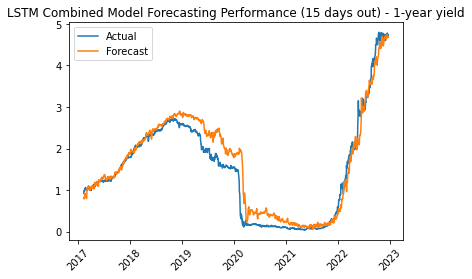

RMSE: 0.5425812018905808
MAPE: 30.50273231142895


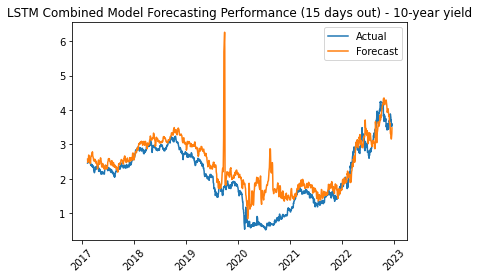

In [59]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_comb_multi_last_day = yhat_comb_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_comb_compare_multi = pd.concat([pd.DataFrame(yhat_comb_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_comb_compare_multi = pd.concat([date_compare, LSTM_comb_compare_multi], axis = 1)
LSTM_comb_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_comb_compare_multi = LSTM_comb_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_comb_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Combined Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_synth_compare_multi, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Combined Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')